In [37]:
import pandas as pd
from scipy.io import loadmat
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

### Capacity (relative to average)

In [38]:
C = 0.1

### Teleportation probability is alpha

In [39]:
alpha = 0.15

### Maximum number of steps is 11

In [40]:
maxSteps = 11

### Load Data from prevous work

In [41]:
Adj = loadmat('Adj.mat')
patient = loadmat('patientNums.mat')

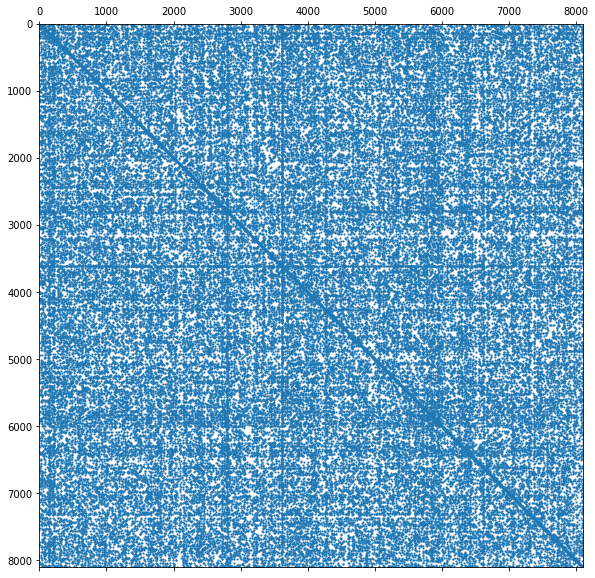

In [42]:
fig = plt.figure(figsize = (10,10))
plt.spy(Adj['Adj'], markersize = 1, precision = 10)

#### Lets work with a 100 doctors for now

In [43]:
docNum = 100

In [44]:
adj  = Adj['Adj'][:docNum,:docNum]
adj = adj.todense()

###  remove self loops

In [45]:
np.fill_diagonal(adj, 0)

#### Load number of patient

In [46]:
mean_patient = patient['MP']

In [47]:
doctors = {}
doctors["originalID"] = np.arange(docNum).squeeze()
print(doctors["originalID"].shape)

(100,)


### Select doctors that are removed

In [48]:
failed = np.random.choice(doctors["originalID"], 2)
print(failed)

[85  1]


In [49]:
lost = 0

In [50]:
doctors["NumOfPatients"] = mean_patient[doctors["originalID"]].astype(int).squeeze() #careful here to put the right ids
doctors["Capacity"] = doctors["NumOfPatients"]*(1+C)

### Doctor Properties

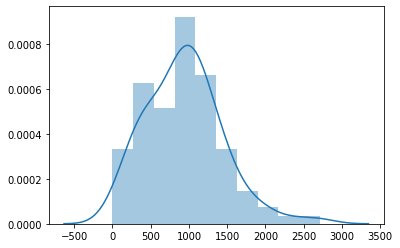

In [51]:
sns.distplot(doctors["NumOfPatients"])

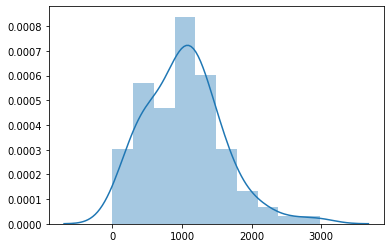

In [52]:
sns.distplot(doctors["Capacity"])

(100,) (100,)


(array([ 9., 17., 14., 25., 18.,  9.,  4.,  2.,  1.,  1.]),
 array([  0. ,  27.1,  54.2,  81.3, 108.4, 135.5, 162.6, 189.7, 216.8,
        243.9, 271. ]),
 <a list of 10 Patch objects>)

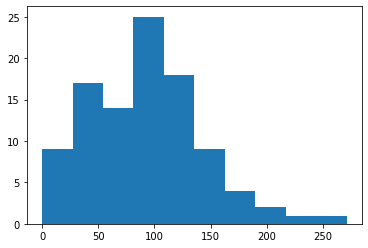

In [53]:
print(doctors["Capacity"].shape, doctors["NumOfPatients"].shape)
plt.hist((doctors["Capacity"]-doctors["NumOfPatients"]).squeeze().astype(int))

In [54]:
G = nx.G=nx.from_numpy_matrix(adj)

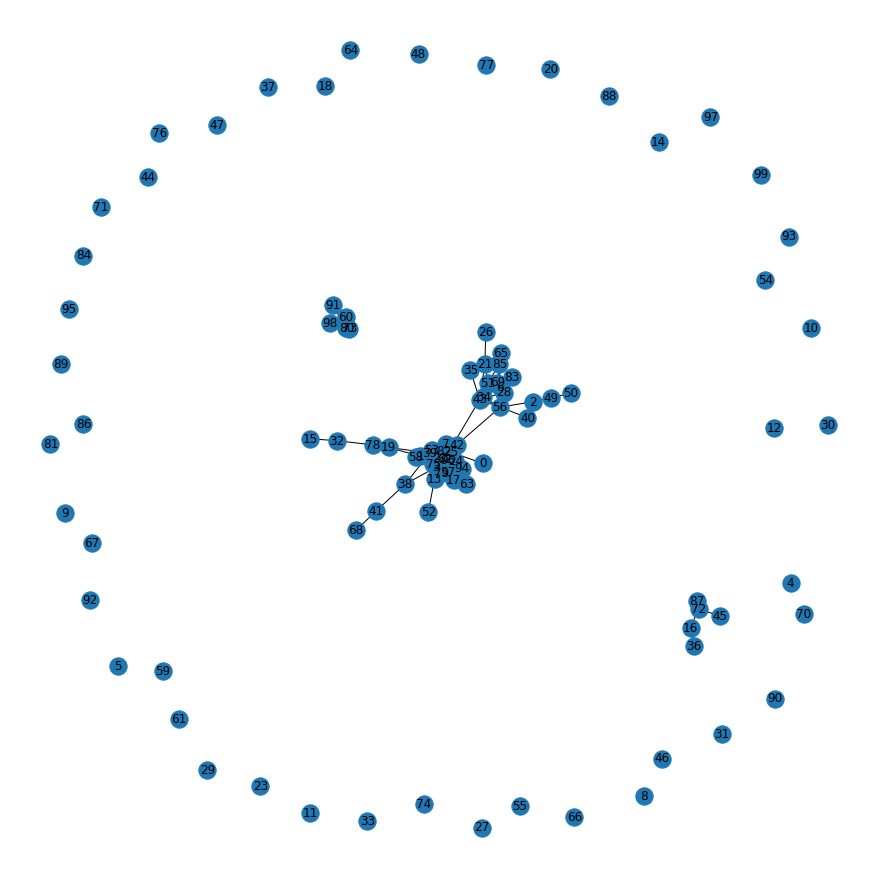

In [55]:
figure = plt.figure(figsize=(12,12))
nx.draw(G, with_labels=True)

In [56]:
totalpatients = doctors["NumOfPatients"][failed].sum()

### Clean out doctors that are disconnected from the network

In [57]:
hasOutDegree = np.any(adj, axis=0).transpose()
hasInDegree = np.any(adj, axis=1)
print(hasInDegree.shape, hasOutDegree.shape)
not_disconnected = np.asarray(np.logical_and(hasOutDegree,hasInDegree)).squeeze()
doctors["originalID"] = doctors["originalID"][not_disconnected.squeeze()]
print(doctors["originalID"])

(100, 1) (100, 1)
[ 1  2  3  6  7 13 16 17 19 21 22 24 25 28 32 34 35 38 39 41 42 43 45 49
 50 51 52 53 56 57 58 60 62 63 65 68 69 72 73 75 78 79 80 82 83 85 87 94
 96 98]


In [58]:
disconnectedFailed = np.logical_not(np.in1d(failed, doctors["originalID"]))

In [59]:
lost+=doctors["NumOfPatients"][failed[disconnectedFailed]].sum()
failed = failed[np.logical_not(disconnectedFailed)]
if failed.size == 0:
    print(lost)

In [60]:
doctors["NumOfPatients"] = doctors["NumOfPatients"][not_disconnected.squeeze()]
doctors["Capacity"] = doctors["Capacity"][not_disconnected.squeeze()]

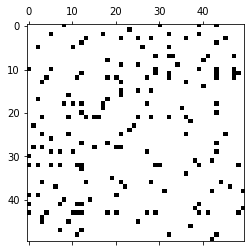

In [61]:
adj = adj[doctors["originalID"], :]
adj = adj[:,doctors["originalID"]]
plt.spy(adj)

### Reindex doctors

In [62]:
doctors["IdForSimulation"] = np.arange(doctors["originalID"].shape[0])
print("original failed: ", failed)
doc2sim = {Id:newID for Id, newID in zip(doctors["originalID"], doctors["IdForSimulation"])}
print(doc2sim)
failed = [doc2sim[f] for f in failed]
print(doctors["IdForSimulation"], failed)

original failed:  [85  1]
{1: 0, 2: 1, 3: 2, 6: 3, 7: 4, 13: 5, 16: 6, 17: 7, 19: 8, 21: 9, 22: 10, 24: 11, 25: 12, 28: 13, 32: 14, 34: 15, 35: 16, 38: 17, 39: 18, 41: 19, 42: 20, 43: 21, 45: 22, 49: 23, 50: 24, 51: 25, 52: 26, 53: 27, 56: 28, 57: 29, 58: 30, 60: 31, 62: 32, 63: 33, 65: 34, 68: 35, 69: 36, 72: 37, 73: 38, 75: 39, 78: 40, 79: 41, 80: 42, 82: 43, 83: 44, 85: 45, 87: 46, 94: 47, 96: 48, 98: 49}
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49] [45, 0]


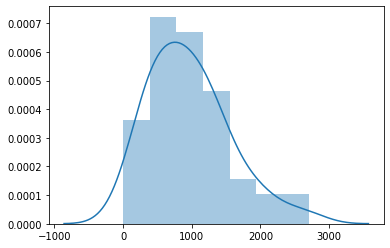

In [63]:
sns.distplot(doctors["NumOfPatients"])

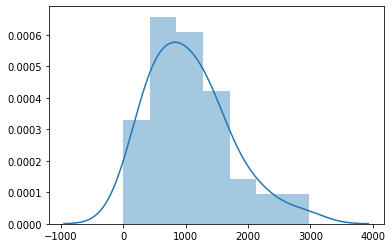

In [64]:
sns.distplot(doctors["Capacity"])

(50,) (50,)


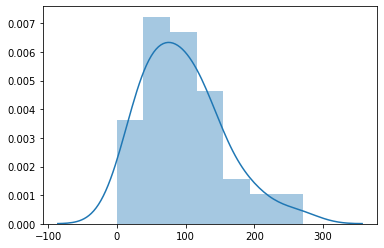

In [65]:
print(doctors["Capacity"].shape, doctors["NumOfPatients"].shape)
sns.distplot((doctors["Capacity"]-doctors["NumOfPatients"]).squeeze().astype(int))

### Randomly select new destination

In [66]:
def vectorized(prob_matrix, items, oldpositions, verbose=False):
    ''''
    Given a probability matrix and a list of items it selects on item based on the column of probability matrix
    '''

    s = prob_matrix.cumsum(axis=0)
    r = np.random.rand(prob_matrix.shape[1])
    k = (s < r).sum(axis=0)
    if verbose:
        print("k-shape: ",k.shape, "prob_matrik-shape: ",prob_matrix.shape, 
              "oldpositions-shape: ",oldpositions.shape, 
              "no_outlinks-IDs: ",np.nonzero(k == prob_matrix.shape[0]))
    k[k == prob_matrix.shape[0]] = oldpositions[np.asarray(k == prob_matrix.shape[0]).squeeze()] #necessary in the case there is no ourlink
    return items[k]

# TimeStep

In [73]:
def step(patient, adj, doctors, lost, alpha = 0.15, maxSteps = 11, verbose = False):

    prob_weights = adj[patient["locations"][ patient["status"].astype(bool)] ] #Create Transport matrix
    #Assign target nodes to patient
    targets = vectorized(prob_weights.transpose(), doctors["IdForSimulation"], 
                         patient["locations"][ patient["status"].astype(bool)] , verbose)
    teleport = np.random.random(targets.shape)<alpha #Choose whether to teleport
    targets[teleport] = np.random.choice(doctors["IdForSimulation"]) #Teleport patient
    patient["locations"][ patient["status"].astype(bool)] = targets.squeeze() #Update locations
    #Count doctors["incoming"] patient
    doctors["incoming"], _ = np.histogram(targets, bins=np.arange(len(doctors["IdForSimulation"])+1))
    at_doc = {}
    for i, doc in enumerate(doctors["IdForSimulation"]):
        at_doc[doc] = np.asarray(patient["locations"][ patient["status"].astype(bool)] == doc).nonzero()[0]
        
        print('%%%%%%%%%%',doctors["incoming"][i]-len(at_doc[doc]))
    doctors["availability"] = (doctors["Capacity"]-doctors["NumOfPatients"]).squeeze().astype(int) #Calculate current availability
    doctors["availability"][doctors["availability"]<0] = 0
    if verbose:
        sns.distplot(doctors["availability"])
        plt.show()
    #Compute how many patient will need to continue their search
    doctors["Excess"] = doctors["incoming"]-doctors["availability"] 
    Absorbed = (doctors["Excess"]<=0) #Check whether doctors have absorbed their load
    #Doctors that have absorbed their load need not send out patient (these would be negative numbers)
    doctors["Excess"][Absorbed] = 0 
    #Compute number of patient per doctor
    doctors["NumOfPatients"][Absorbed] =  doctors["NumOfPatients"][Absorbed] + doctors["incoming"][Absorbed]
    #Fill up doctors that have not absorbed the load
    doctors["NumOfPatients"][np.logical_not(Absorbed)] = doctors["Capacity"][np.logical_not(Absorbed)]
    #Patients at doctor that have absorbed can stop
    patient["status"][ np.in1d(patient["locations"], doctors["IdForSimulation"][Absorbed]) ] = 0 
    
    patient["displacements"][ patient["status"].astype(bool) ]+=1 #Update number of displacements
    # Randomply pick patient that can stay at doctors that have filled up
    for doc in doctors["IdForSimulation"]: 
        # Skip doctors with now patient doctors["incoming"]
        if doctors["incoming"][doc] and not Absorbed[doc] and doctors["availability"][doc] != 0:
            #Determine indices of patient at location
#             at_doc = np.asarray(patient["locations"][ patient["status"].astype(bool)] == doc).nonzero()[0] 
            #Randomly pick the patient
            if verbose:
                print("at_doc-shape: ", at_doc[doc].shape, "availability: ", doctors["availability"][doc].astype(int))
            kept = np.random.choice(at_doc[doc], size = doctors["availability"][doc], replace = False)
            print(kept.size)
            patient["status"][kept] = 0 #Change status of the lucky ones
    patient["status"][ patient["displacements"]>=maxSteps ] = 0
    lost+= np.array(patient["displacements"]>maxSteps).sum()
    print("Active Patients",patient["status"].sum())
    return patient, doctors, lost

### Patient Status and number of displacements per patient (1 = searching, 0 = found doctor)

In [74]:
patient = {}
patient["locations"] = np.hstack(np.array([i*np.ones(NPats) 
                                    for i, NPats in zip(failed,
                                                        doctors["NumOfPatients"][failed])])).astype(int).squeeze()
patient["status"] = np.ones(patient["locations"].shape, dtype=bool)
patient["displacements"] = np.zeros(patient["locations"].shape)

Active Patients 2372
1
k-shape:  (1, 2372) prob_matrik-shape:  (50, 2372) oldpositions-shape:  (2372,) no_outlinks-IDs:  (array([], dtype=int64), array([], dtype=int64))
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0


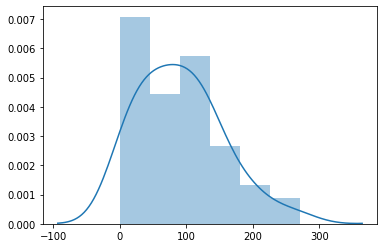

at_doc-shape:  (320,) availability:  120
120
Active Patients 2252
2
k-shape:  (1, 2252) prob_matrik-shape:  (50, 2252) oldpositions-shape:  (2252,) no_outlinks-IDs:  (array([], dtype=int64), array([], dtype=int64))
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0
%%%%%%%%%% 0


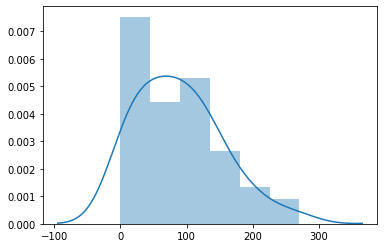

at_doc-shape:  (344,) availability:  8
8
at_doc-shape:  (1018,) availability:  167
167
at_doc-shape:  (716,) availability:  237
237
at_doc-shape:  (174,) availability:  69
69
Active Patients 1795
3
k-shape:  (1, 1795) prob_matrik-shape:  (50, 1795) oldpositions-shape:  (1795,) no_outlinks-IDs:  (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

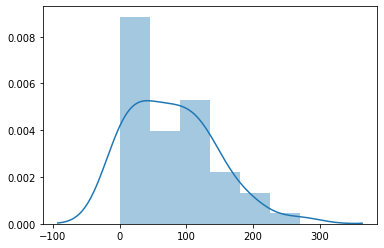

Active Patients 1667
4
k-shape:  (1, 1667) prob_matrik-shape:  (50, 1667) oldpositions-shape:  (1667,) no_outlinks-IDs:  (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0]), array([   2,   24,   26,   31,   35,   36,   53,   65,   80,   84,   95,
        120,  126,  174,  175,  177,  179,  205,

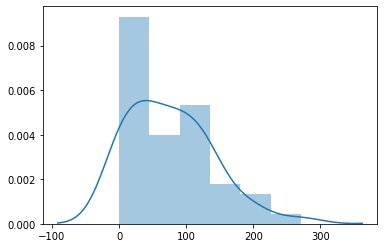

at_doc-shape:  (256,) availability:  25
25
Active Patients 1653
5
k-shape:  (1, 1653) prob_matrik-shape:  (50, 1653) oldpositions-shape:  (1653,) no_outlinks-IDs:  (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([   2,   24,   31,   35,   53,   65,   80,   84,   95,  120,  126,
        174,  177,  179,  205,  218,  219,  220,  222,  228,  246,  248,
        283,  284,  289,  301,  309,  321,  326,  333,  335,  3

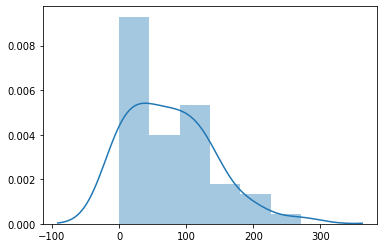

at_doc-shape:  (210,) availability:  40
40
at_doc-shape:  (217,) availability:  44
44
at_doc-shape:  (225,) availability:  141
141
Active Patients 1487
6
k-shape:  (1, 1487) prob_matrik-shape:  (50, 1487) oldpositions-shape:  (1487,) no_outlinks-IDs:  (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0]), array([  25,   51,   66,   70,   80,  148,  151,  175,  187,  189,  209,
        240,  241,  245,  262,  274,  278,  285,  287,  297,  298,  314,
        333,  335,  344,  356,  362,  380,  397,  407,  413,  421,  425,
        440,  459,  463,  473,  488,  490,  493,  500,  532,  533,  538,
  

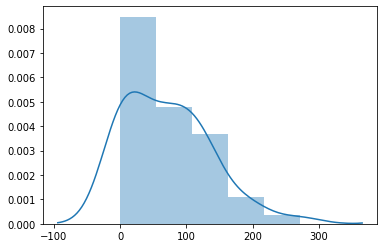

at_doc-shape:  (160,) availability:  35
35
at_doc-shape:  (214,) availability:  107
107
Active Patients 1392
7
k-shape:  (1, 1392) prob_matrik-shape:  (50, 1392) oldpositions-shape:  (1392,) no_outlinks-IDs:  (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

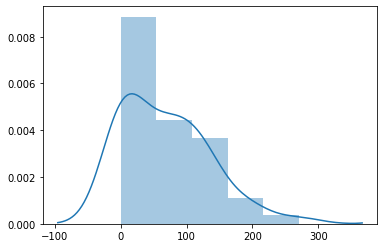

at_doc-shape:  (125,) availability:  39
39
at_doc-shape:  (204,) availability:  127
127
at_doc-shape:  (169,) availability:  120
120
Active Patients 1232
8
k-shape:  (1, 1232) prob_matrik-shape:  (50, 1232) oldpositions-shape:  (1232,) no_outlinks-IDs:  (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0]), array([  12,   29,   33,   34,   42,   44,   46,   55,   68,   79,   94,
   

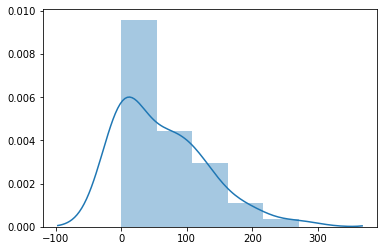

at_doc-shape:  (150,) availability:  132
132
Active Patients 1179
9
k-shape:  (1, 1179) prob_matrik-shape:  (50, 1179) oldpositions-shape:  (1179,) no_outlinks-IDs:  (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0]), array([  10,   27,   31,   32,   40,   42,   44,   53,   74,   88,   93,
         94,   96,  100,  107,  120,  135,  142,  143,  153,  154,  157,
        170,  201,  203,  206,  210,  212,  219,  223,  226,  227,  236,
        248,  258,  261,  264,  277,  286,  288,  292,  293,  297,  309,
   

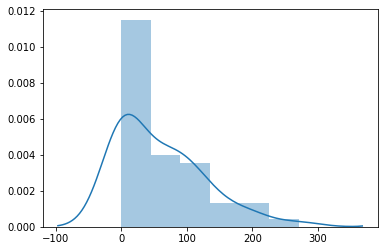

at_doc-shape:  (115,) availability:  30
30
Active Patients 1167
10
k-shape:  (1, 1167) prob_matrik-shape:  (50, 1167) oldpositions-shape:  (1167,) no_outlinks-IDs:  (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0]), array([  27,   31,   32,   40,   42,   44,   53,   74,   87,   92,   93,
         94,   98,  104,  131,  136,  146,  147,  150,  163,  199,  203,
        205,  212,  216,  219,  220,  229,  241,  251,  254,  257,  269,
        278,  280,  285,  288,  300,  305,  307,  328,  334,  340,  368,
        388,  404,  409,  412,  413,  421,  422,  439,  445,  450,  462,
        47

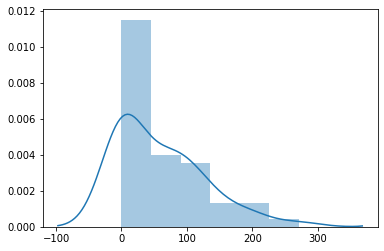

Active Patients 1167
11
k-shape:  (1, 1167) prob_matrik-shape:  (50, 1167) oldpositions-shape:  (1167,) no_outlinks-IDs:  (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([  40,   42,   44,   53,   74,   87,   92,   93,   98,  104,  136,
        146,  147,  150,  163,  199,  203,  205,  212,  216,  219,  220,
        241,  251,  254,  257,  269,  278,  285,  288,  300,  305,  328,
        334,  340,  368,  388,  404,  409,  412,  413,  421,  422,  439,
        445,  450,  462,  470,  493,  499,  500,  505,  517,  540,  554,
        563,  564,  576,  579,  580,  587,  588,  594,  595,  611,  617,
        624,  635,  654,  656,  660

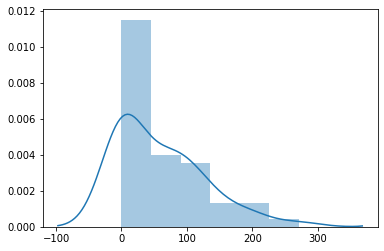

at_doc-shape:  (165,) availability:  78
78
Active Patients 0


In [75]:
adj[:,failed] = 0
t = 1
print("Active Patients",patient["status"].sum())
while np.any(patient["status"]):
    print(t)
    patient, doctors, lost = step(patient, adj, doctors, lost, verbose = True)
    t+=1

In [34]:
patient['status'].sum()/patient['status'].shape[0]

0.0

In [35]:
print(lost)
print(lost/totalpatients)

1521
0.6145454545454545


In [36]:
totalpatients

2475

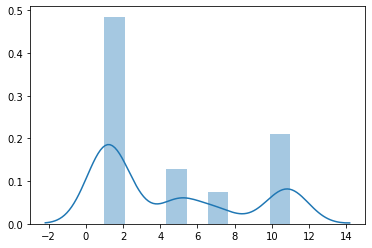

In [37]:
sns.distplot(patient["displacements"])